In [85]:
import sys
import os
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import time

def L99_thickness(filename_prefix,t):
    fname = filename_prefix+'L99.dat'
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)

    nstats=2
    dat = np.reshape(dat,[n/nstats,nstats])
    time = dat[:,0]
    L99 = dat[:,1]
    
    idx = np.argmin(abs(time-t))
    return L99[idx]    

xdir=0; ydir=1; zdir=2;

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/256x512x128/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/512x724x256/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr7/256x512x128/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr_7/256x512x128/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/256x512x128/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/512x724x256/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/1024x1024x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr7/1024x1024x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr_7/1024x1024x512/'

# directory = "/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/724x724x256/"
directory = "/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/1024x1024x512/"

filename_prefix = directory+'/shearlayer_'
reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))
Nx,Ny,Nz,Lx,Ly,Lz,dx,dy,dz,kx,kz = stats.domain(reader,verbose=1)
x, y, z = reader.readCoordinates()
xplot = np.squeeze(x[:,0,0])
yplot = np.squeeze(y[0,:,0])
zplot = np.squeeze(z[0,0,:])
steps = sorted(reader.steps)
print("Steps: {}".format(reader.steps))

Domain size: 100.0 x 99.90234375 x 50.0
Grid size: 1024 x 1024 x 512
Grid res: 0.09765625 x 0.09765625 x 0.09765625
Steps: (0, 1, 2, 3, 4, 5, 6, 16, 17, 18)


Time: 800.0
L99 = 26.611328125


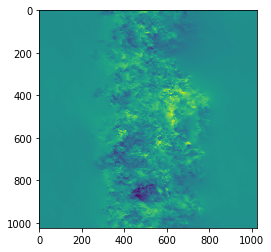

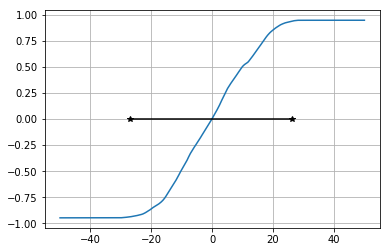

In [81]:
reader.step = 17
print("Time: {}".format(reader.time))

# Get fluctuations
vp = reader.readData('v')
vp = np.squeeze(np.array(vp))
plt.figure()
plt.imshow(vp[:,:,1])

# Get mean ubar
u = reader.readData('u')
u = np.squeeze(np.array(u))
ubar = np.mean(np.mean(u,axis=zdir),axis=xdir)

# 99% Thickness
du = ubar[-1]-ubar[0]
utop = 0.99*du/2
ubot = -0.99*du/2
i1 = np.argmin(abs(ubar[:Ny/2]-ubot))
i2 = np.argmin(abs(ubar[Ny/2:]-utop)) + Ny/2
L99 = (yplot[i2]-yplot[i1])/2.

plt.figure()
plt.plot(yplot,ubar)
plt.plot([yplot[i1],yplot[i2]],[0,0],'k-*')
plt.grid(True)
print("L99 = {}".format(L99))

(246, 266)
Integral Ly = 25.9765625
L_int/L99 = 0.976146788991


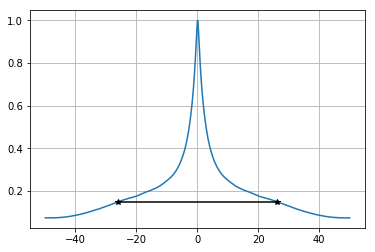

In [82]:
# Lengthscale thickness (transverse)
R22_mean = np.zeros([Ny])
for xi in range(0,Nx,10):
    for zi in range(0,Nz,10):
        uhat = np.fft.fftshift(np.fft.fft(vp[xi,:,zi]))
        R22hat = uhat*np.conj(uhat)#autocorr
        R22 = np.abs(np.fft.ifft(R22hat))
        R22 = np.fft.ifftshift(R22)
        R22 /= R22.max()
        R22_mean += R22
R22_mean = R22_mean/R22_mean.max()

thresh = 0.15
i1 = np.argmin(abs(R22_mean[:Ny/2]-thresh))
i2 = np.argmin(abs(R22_mean[Ny/2:]-thresh))
L_int = abs(yplot[i1]-yplot[Ny/2+i2])/2.

plt.plot(yplot,R22_mean)
plt.plot([yplot[i1],yplot[Ny/2+i2]],[thresh,thresh],'k-*')
plt.grid(True)

print(i1,i2)
print("Integral Ly = {}".format(L_int))
print("L_int/L99 = {}".format(L_int/L99))

Text(0,0.5,'$L/\\delta_{99}$')

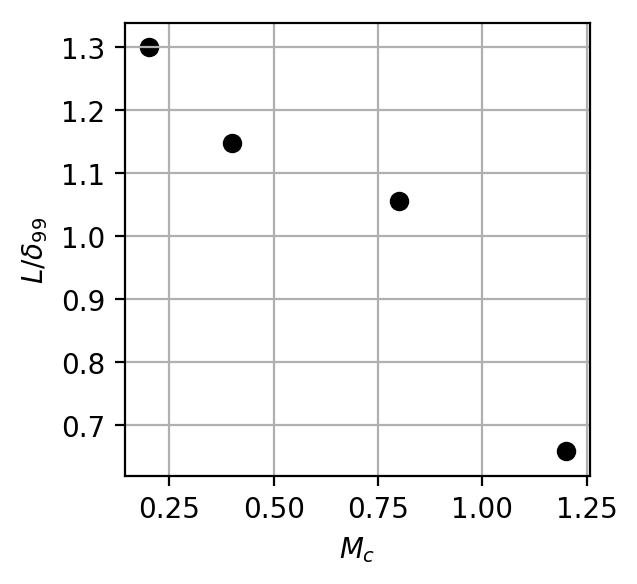

In [107]:
ly_norm = { #using vv
    #0.2: 1.3, #256x512, step 40
    0.2: 1.41, #512x724, step 60
    0.4: 1.148, # 256x512, step 30
    #0.8: 1.056, # 512x724, step 5
    0.8: 0.9761, # 1024x1024, step 40
    #1.2: 0.659 # 724x724, step 10, thresh = ?
    1.2: 0.784 # 1024x1024, step 17, thresh=0.15
}
fs = 14
fig = plt.figure(figsize=(3,3),dpi=200)
plt.scatter(ly_norm.keys(),ly_vv.values(),c='k')
plt.grid(True)
plt.xlabel(r'$M_c$')
plt.ylabel(r'$L/\delta_{99}$')


# ly_norm = { # using uu
#     0.2: 1.25, #256x512, step 40
#     #0.2, 1.08, #512x724
#     0.4: 0.932, # 256x512
#     0.8: 0.811, # 1024x1024, step 40
#     #1.2: 0.394 # 724x724, step 10
#     1.2: 0.616 # 1024x1024, step 17
# }
# plt.scatter(ly_norm.keys(),ly_norm.values(),c='r')
# plt.legend([r'$l_v$',r'$l_u$'])


0.05035393407969512


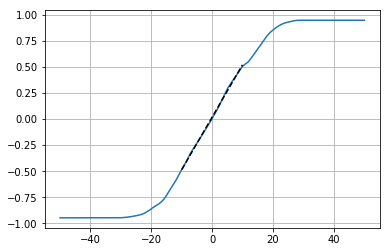

In [101]:
# Compute the gradient at the centerline

ts = np.argmin(abs(yplot+10))
te = np.argmin(abs(yplot-10))
t_fit = yplot[ts:te+1]
dat_fit = ubar[ts:te+1]
S,shift = np.polyfit(t_fit, dat_fit, 1) #linear fit
print(S)

plt.figure()
plt.plot(yplot,ubar)
plt.grid(True)
plt.plot(t_fit,t_fit*growth_rate+shift,'k--')

In [1]:
T = reader.readData('T')
c = np.squeeze(np.array((T)))**0.5
cbar = np.mean(np.mean(c,axis=zdir),axis=xdir)
cbar = cbar[Ny/2]*gamma**0.5
plt.plot(cbar)

NameError: name 'reader' is not defined

In [105]:
Mg = S*L_int/cbar
dU_Mg = Mg*cbar;

print(cbar)
print(Mg)
print(dU_Mg)

1.1832159566199232
1.1054804563984155
1.3080221157420806
